In [1]:
# binder https://hub.gke.mybinder.org/user/blychs-climatologia_fisica-dckeuhha/notebooks/practica2.ipynb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import copy
import datetime as dt
import calendar
import seaborn as sns
import regionmask
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib as mpl
#from funciones_meteo import load_file, ploteo_general, calculate_h

In [2]:
class Celda():
    def __init__(self, lat, lon):
        self.lat = lat
        self.lon = lon

In [3]:
def area_banda(lat1, lat2):
    """Calcula el area de una banda de latitudes"""
    r = 6371000
    cap = lambda x: 2 * np.pi * (6371000**2) * np.abs(np.sin(np.deg2rad(x)) - 1)
    a1 = cap(lat1)
    a2 = cap(lat2)
    return np.abs(cap(lat1) - cap(lat2))


def area_celda(lat, delta_lat=2.5, delta_lon=2.5):
    """Calcula el area de una celda de lat
    en base a una celda central"""
    return (np.abs(delta_lon) / 360 * area_banda(lat-(delta_lat/2),lat+(delta_lat/2)))


def xr_trends(xarray):
    """ Calcula la tendencia
    lineal de un xarray en el tiempo"""
    vals = xarray.values
    years = xarray.time.dt.year.values
    # Reshape to an array with as many rows as years and as many columns as there are pixels
    vals2 = vals.reshape(len(years), -1)
    # Do a first-degree polyfit
    regressions = np.polyfit(years, vals2, 1)
    # Get the coefficients back
    trends = regressions[0,:].reshape(vals.shape[1], vals.shape[2])
    da_trends = xr.DataArray(trends, coords={'lat': xarray.lat,
                                             'lon': xarray.lon},
                            dims=['lat', 'lon'])
    return da_trends


def regrid(xarray):
    """Lleva a una grilla con los puntos entre 2 puntos
    adyacentes de la original que tenemos"""
    new_grid = np.linspace(-88.75, 88.75, len(xarray.lat) - 1)
    return xarray.interp(lat=new_grid)


def covariance(x,y,dims=None):
    return xr.dot(x-x.mean(dims), y-y.mean(dims), dims=dims) / x.count(dims)


def correlation(x,y,dims=None):
    return covariance(x,y,dims) / (x.std(dims) * y.std(dims))

In [4]:
# Definicion de máscaras
pr_obs = xr.open_dataset('observacionales/precip.mon.total.v7_197601-200512_2.5_anu.nc')
mask_land = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(pr_obs.precip.isel(time=0))
mask_ocean = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isnan(pr_obs.precip.isel(time=0))
t_land = xr.open_dataset('observacionales/tmp_cru_ts3.20_197601-200512_2.5_anu.nc')
t_ocean = xr.open_dataset('observacionales/sst.mnmean.v4_197601-200512_2.5_anu.nc')
t_global = t_land.tmp.combine_first(t_ocean.sst)


#ax = plt.axes(projection=ccrs.PlateCarree())
#mask_land.where(mask_land.lat<11).where(mask_land.lat > -59).where(mask_land.lon>270).where(
#    mask_land.lon < 330).plot(transform=ccrs.PlateCarree())
#ax.coastlines()
#plt.show()

# ax = plt.axes(projection=ccrs.PlateCarree())
# 
# mask_north_am.plot(transform=ccrs.PlateCarree())
# ax.gridlines(label=True)
# ax.coastlines()
# plt.show()
# 
# ax = plt.axes(projection=ccrs.PlateCarree())
# 
# mask_south_am.plot(transform=ccrs.PlateCarree())
# ax.gridlines(label=True)
# ax.coastlines()
# plt.show()


mask_north_am = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat > 11).where(mask_land.lon>185).where(
                             mask_land.lon < 310))
mask_north_am += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                              mask_land.where(mask_land == 1).where(
                              mask_land.lat > 59).where(mask_land.lon>=310).where(
                              mask_land.lon < 345))

mask_south_am = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat < 11).where(mask_land.lon>270).where(
                             mask_land.lon < 330))


mask_africa = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat<37).where(
                             mask_land.lat>-37).where(
                             mask_land.lon>340).where(mask_land.lon < 360))
mask_africa += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat<37).where(
                             mask_land.lat>-37).where(
                             mask_land.lon>=0).where(mask_land.lon<32))
mask_africa += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat<35).where(
                             mask_land.lat>-37).where(
                             mask_land.lon>=32).where(mask_land.lon<35))
mask_africa += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat<27).where(
                             mask_land.lat>-37).where(
                             mask_land.lon>=35).where(mask_land.lon<37))
mask_africa += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat<25).where(
                             mask_land.lat>-37).where(
                             mask_land.lon>=37).where(mask_land.lon<40))
mask_africa += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat<20).where(
                             mask_land.lat>-37).where(
                             mask_land.lon>=40).where(mask_land.lon<42))
mask_africa += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat<17).where(
                             mask_land.lat>-37).where(
                             mask_land.lon>=42).where(mask_land.lon<43))
mask_africa += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat<11).where(
                             mask_land.lat>-37).where(
                             mask_land.lon>=43).where(mask_land.lon<55))

mask_europe = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat>37).where(
                             mask_land.lat<70).where(
                             mask_land.lon>350).where(mask_land.lon < 360))
mask_europe += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat>37).where(
                             mask_land.lat<80).where(
                             mask_land.lon>=0).where(mask_land.lon<32))
#mask_europe += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
#                             mask_land.where(mask_land == 1).where(
#                             mask_land.lat>37).where(
#                             mask_land.lat<80).where(
#                             mask_land.lon>=37).where(mask_land.lon<50))


#plt.figure(figsize=(20,10))
#ax = plt.axes(projection=ccrs.PlateCarree())
#mask_europe.plot()
# mask_land.where(mask_land.lat<22).where(mask_land.lat>-37).where(
#     mask_land.lon>=0).where(
#     mask_land.lon<42).plot(transform=ccrs.PlateCarree(), add_colorbar=False)
# mask_land.where(mask_land.lat<17).where(mask_land.lat>-37).where(
#     mask_land.lon>=0).where(
#     mask_land.lon<44).plot(transform=ccrs.PlateCarree(), add_colorbar=False)
# mask_land.where(mask_land.lat<11).where(mask_land.lat>-37).where(
#     mask_land.lon>=0).where(
#     mask_land.lon<55).plot(transform=ccrs.PlateCarree(), add_colorbar=False)
#ax.coastlines()
#ax.gridlines()
#plt.show()

In [5]:
# Load files CMIP5

pr_c5_hist = xr.open_mfdataset('NorESM1-M/pr_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc',
                              combine='nested',
                              concat_dim='r')['pr']
pr_c5_ens = pr_c5_hist.mean(dim='r', keep_attrs=True)
pr_c5_26_close = xr.open_dataset('NorESM1-M/pr_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc'
                                )['pr']
pr_c5_26_far = xr.open_dataset('NorESM1-M/pr_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc'
                                )['pr']
pr_c5_85_close = xr.open_dataset('NorESM1-M/pr_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc'
                                )['pr']
pr_c5_85_far = xr.open_dataset('NorESM1-M/pr_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc'
                                )['pr']
# """"""""""""""""""""""""""""""""""""""""""
ev_c5_hist = xr.open_mfdataset('NorESM1-M/evspsbl_Amon_NorESM1-M_historical_r1i1p1_197601-200512_2.5_anu.nc',
                               combine='nested',
                               concat_dim='r')['evspsbl']
ev_c5_ens = ev_c5_hist.mean(dim='r', keep_attrs=True)
ev_c5_26_close = xr.open_dataset('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc'
                                )['evspsbl']
ev_c5_26_far   = xr.open_dataset('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc'
                                )['evspsbl']
ev_c5_85_close = xr.open_dataset('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc'
                                )['evspsbl']
ev_c5_85_far   = xr.open_dataset('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc'
                                )['evspsbl']
# """"""""""""""""""""""""""""""""""""""""""
ep_c5_hist = xr.open_mfdataset('NorESM1-M/etp_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc',
                               combine='nested',
                               concat_dim='r')['etp']
ep_c5_ens = ep_c5_hist.mean(dim='r', keep_attrs=True)
ep_c5_26_close = xr.open_dataset('NorESM1-M/etp_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc'
                                )['etp']
ep_c5_26_far   = xr.open_dataset('NorESM1-M/etp_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc'
                                )['etp']
ep_c5_85_close = xr.open_dataset('NorESM1-M/etp_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc'
                                )['etp']
ep_c5_85_far   = xr.open_dataset('NorESM1-M/etp_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc'
                                )['etp']
# """"""""""""""""""""""""""""""""""""""""""""

t_c5_hist = xr.open_mfdataset('NorESM1-M/tas_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc',
                              combine='nested',
                              concat_dim='r')['tas']
t_c5_ens = t_c5_hist.mean(dim='r', keep_attrs=True)
t_c5_26_close = xr.open_dataset('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc'
                               )['tas']
t_c5_26_far   = xr.open_dataset('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc'
                               )['tas']
t_c5_85_close = xr.open_dataset('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc'
                               )['tas']
t_c5_85_far   = xr.open_dataset('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc'
                               )['tas']
# """"""""""""""""""""""""""""""""""""""
q_c5_hist = xr.open_mfdataset('NorESM1-M/huss_historical_r*_anu.nc',
                            combine='nested',
                            concat_dim='r')['huss']
q_c5_ens = q_c5_hist.mean(dim='r', keep_attrs=True)
q_c5_26_close = xr.open_dataset('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_202001-204912_2.5_anu.nc'
                               )['huss']
q_c5_26_far   = xr.open_dataset('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_207001-209912_2.5_anu.nc'
                               )['huss']
q_c5_85_close = xr.open_dataset('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_202001-204912_2.5_anu.nc'
                               )['huss']
q_c5_85_far   = xr.open_dataset('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_207001-209912_2.5_anu.nc'
                               )['huss']

In [6]:
# Load files CMIP6
pr_c6_hist = xr.open_mfdataset('NorESM2-LM/pr_Amon_NorESM2-LM_historical_r*_2.5_anu.nc',
                              combine='nested',
                              concat_dim='r')['pr']
pr_c6_ens = pr_c6_hist.mean(dim='r', keep_attrs=True)
pr_c6_126_close = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc',
                                 )['pr']
pr_c6_126_far   = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc'
                                 )['pr']
pr_c6_585_close = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_anu.nc'
                                 )['pr']
pr_c6_585_far   = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_anu.nc'
                                 )['pr']
# """"""""""""""""""""""""""""""""""""""
ev_c6_hist = xr.open_mfdataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_historical_r*_2.5_anu.nc',
                               combine='nested',
                               concat_dim='r')['evspsbl']
ev_c6_ens = ev_c6_hist.mean(dim='r', keep_attrs=True)
ev_c6_126_close = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc'
                                 )['evspsbl']
ev_c6_126_far   = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc'
                                 )['evspsbl']
ev_c6_585_close = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp585_r1i1p1f1_gn_2020-2049_2.5_anu.nc'
                                 )['evspsbl']
ev_c6_585_far   = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp585_r1i1p1f1_gn_2070-2099_2.5_anu.nc'
                                 )['evspsbl']
# """"""""""""""""""""""""""""""""""""""
ep_c6_hist = xr.open_mfdataset('NorESM2-LM/etp_Amon_NorESM2-LM_historical_r*_2.5_anu.nc',
                               combine='nested',
                               concat_dim='r')['etp']
ep_c6_ens = ep_c6_hist.mean(dim='r', keep_attrs=True)
ep_c6_126_close = xr.open_dataset('NorESM2-LM/etp_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc'
                                 )['etp']
ep_c6_126_far   = xr.open_dataset('NorESM2-LM/etp_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc'
                                 )['etp']
ep_c6_585_close = xr.open_dataset('NorESM2-LM/etp_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_anu.nc'
                                 )['etp']
ep_c6_585_far   = xr.open_dataset('NorESM2-LM/etp_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_anu.nc'
                                 )['etp']
# """"""""""""""""""""""""""""""""""""""
t_c6_hist = xr.open_mfdataset('NorESM2-LM/tas_Amon_NorESM2-LM_historical_r*_2.5_anu.nc',
                              combine='nested',
                              concat_dim='r')['tas']
t_c6_ens = t_c6_hist.mean(dim='r', keep_attrs=True)
t_c6_126_close = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc'
                                )['tas']
t_c6_126_far   = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc'
                                )['tas']
t_c6_585_close = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_anu.nc'
                                )['tas']
t_c6_585_far   = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_anu.nc'
                                )['tas']
# """"""""""""""""""""""""""""""""""""""
q_c6_hist = xr.open_mfdataset('NorESM2-LM/huss_Amon_NorESM2-LM_historical_r*_2.5.nc',
                              combine='nested',
                              concat_dim='r')['huss']
q_c6_ens = q_c6_hist.mean(dim='r', keep_attrs=True)
q_c6_126_close = xr.open_dataset('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc'
                                )['huss']
q_c6_126_far   = xr.open_dataset('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc'
                                )['huss']
q_c6_585_close = xr.open_dataset('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc'
                                )['huss']
q_c6_585_far   = xr.open_dataset('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc'
                                )['huss']
# """"""""""""""""""""""""""""""""""""""

In [7]:
t_c6_ens.shape

(30, 73, 144)

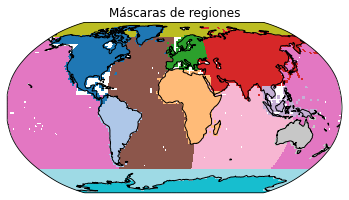

In [100]:
pr_obs = xr.open_dataset('observacionales/precip.mon.total.v7_197601-200512_2.5_anu.nc')
mask_land = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(pr_obs.precip.isel(time=0))
mask_ocean = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isnan(pr_obs.precip.isel(time=0))
t_land = xr.open_dataset('observacionales/tmp_cru_ts3.20_197601-200512_2.5_anu.nc')
t_ocean = xr.open_dataset('observacionales/sst.mnmean.v4_197601-200512_2.5_anu.nc')
t_global = t_land.tmp.combine_first(t_ocean.sst)


maskSR = regionmask.defined_regions.srex.mask(pr_c5_ens)
maskLND = regionmask.defined_regions.natural_earth.land_110.mask(pr_c5_ens)
#print(regionmask.defined_regions.srex.map_keys)
mask_NA = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==1))
for i in range(2,7):
    mask_NA += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==i))

mask_SA = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==7))

for i in range(8,11):
        mask_SA += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==i))
        

mask_EU = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==11))

mask_EU += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                        mask_land.where(mask_land == 1).where(
                        maskSR==12))

mask_EU += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                        mask_land.where(mask_land == 1).where(
                        maskSR==13).where(mask_land.lat > 37).where(mask_land.lon < 30))

mask_EU += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                        mask_land.where(mask_land == 1).where(
                        maskSR==13).where(mask_land.lat > 37).where(mask_land.lon > 300))

mask_AF = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==14))

mask_AF += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                        mask_land.where(mask_land == 1).where(
                        maskSR==13).where(mask_land.lat <= 37).where(mask_land.lon < 30))

mask_AF += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                        mask_land.where(mask_land == 1).where(
                        maskSR==13).where(mask_land.lat <= 37).where(mask_land.lon > 300))

for i in range(15,18):
        mask_AF += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==i))
        
mask_AS = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==18))

mask_AS += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==13).where(mask_land.lon>=30).where(mask_land.lon<180))

for i in range(19,24):
        mask_AS += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==i))
mask_AS += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             mask_land.lat>70).where(mask_land.lon >= 35).where(mask_land.lon <=180))

mask_MA = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==24))


mask_AU = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==25))
mask_AU += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(mask_land == 1).where(
                             maskSR==26))

mask_AN = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                             mask_land.where(np.isfinite(maskLND)).where(mask_land.lat < -60))


mask_OA = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                            mask_ocean.where(mask_ocean==1).where(np.isnan(maskLND)).where(
                                mask_ocean.lon > 290).where(mask_ocean.lat<70).where(mask_ocean.lat>-60))

mask_OA += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                            mask_ocean.where(mask_ocean==1).where(np.isnan(maskLND)).where(
                                mask_ocean.lon >= 0).where(mask_ocean.lon < 25).where(
                                mask_ocean.lat<5).where(mask_ocean.lat>-60))

mask_OA += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                            mask_ocean.where(mask_ocean==1).where(np.isnan(maskLND)).where(
                                mask_ocean.lon <= 290).where(mask_ocean.lon > 288).where(
                                mask_ocean.lat < 70).where(mask_ocean.lat >- 60))

mask_OP = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                            mask_ocean.where(mask_land==0).where(
                                mask_ocean.lon < 290).where(mask_ocean.lon>180).where(
                                mask_ocean.lat>-60).where(mask_ocean.lat<11))
mask_OP += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                            mask_ocean.where(mask_ocean==1).where(
                                mask_ocean.lon < 255).where(mask_ocean.lon>180).where(
                                mask_ocean.lat>=11).where(mask_ocean.lat<70))
mask_OP += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                            mask_ocean.where(mask_ocean==1).where(
                                mask_ocean.lon < 180).where(mask_ocean.lon>120).where(
                                mask_ocean.lat>=0).where(mask_ocean.lat<70))
mask_OP += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                            mask_ocean.where(mask_ocean==1).where(
                                mask_ocean.lon < 180).where(mask_ocean.lon>=130).where(
                                mask_ocean.lat>-60).where(mask_ocean.lat<0))


mask_OI = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                            mask_ocean.where(mask_ocean==1).where(np.isnan(maskLND)).where(
                                mask_ocean.lon < 130).where(mask_ocean.lon >= 25).where(
                                mask_ocean.lat>-60).where(mask_ocean.lat<-5))
mask_OI += 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                            mask_ocean.where(mask_ocean==1).where(np.isnan(maskLND)).where(
                                mask_ocean.lon < 100).where(mask_ocean.lon>25).where(
                                mask_ocean.lat>=-5).where(mask_ocean.lat<25))

mask_OAr = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                            mask_ocean.where(mask_ocean==1).where(np.isnan(maskLND)).where(
                                mask_ocean.lat>=70))

mask_OAn = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(
                            mask_ocean.where(mask_ocean==1).where(np.isnan(maskLND)).where(
                                mask_ocean.lat<=-60))



mask_all = mask_NA + 2 * mask_SA + 3 * mask_AF + 4 * mask_EU + 5 * mask_AS +\
           7 * mask_MA + 8 * mask_OA + 9 * mask_OP + 10 * mask_OI + 11 * mask_AU +\
           12 * mask_OAr + 13 * mask_AN + 14 * mask_OAn


ax = plt.axes(projection=ccrs.Robinson())
mask_all.where(mask_all > 0).plot(transform=ccrs.PlateCarree(), cmap='tab20', add_colorbar=False)
ax.coastlines()
plt.title('Máscaras de regiones')
plt.show()


masks_land = {'Norteamérica': mask_NA, 'Sudamérica': mask_SA, 'África': mask_AF,
            'Europa': mask_EU, 'Asia':mask_AS, 'Cont. Marítimo': mask_MA,
             'Australia': mask_AU, 'Antártida': mask_AN, }
masks_ocean = {'Atĺántico': mask_OA, 'Pacífico': mask_OP, 'Índico': mask_OI,
               'Ártico':  mask_OAr, 'Antártico': mask_OAn}

In [9]:
area_sudam = (area_celda(masks_ocean['Pacífico'].lat.where(masks_ocean['Pacífico']==1)).sum() / 10**12)
print(area_sudam.values)

151.2750213462864


In [10]:
dict_pr_ev_c5 = {'hist':[pr_c5_hist, ev_c5_hist],
                 'RCP26':[[pr_c5_26_close, ev_c5_26_close], [pr_c5_26_far, ev_c5_26_far]],
                 'RCP85':[[pr_c5_85_close, ev_c5_85_close],[pr_c5_85_far, ev_c5_85_far]]}

dict_pr_ev_c6 = {'hist':[pr_c6_hist, ev_c6_hist],
                 'SSP126':[[pr_c6_126_close, ev_c6_126_close], [pr_c6_126_far, ev_c6_126_far]],
                 'SSP585':[[pr_c6_585_close, ev_c6_585_close], [pr_c6_585_far, ev_c6_585_far]]}



In [11]:
dict_t_c5 = {'hist':[t_c5_hist],
             'RCP26':[[t_c5_26_close], [t_c5_26_far]],
             'RCP85':[[t_c5_85_close],[t_c5_85_far]]}

dict_t_c6 = {'hist':[t_c6_hist],
             'SSP126':[[t_c6_126_close], [t_c6_126_far]],
             'SSP585':[[t_c6_585_close], [t_c6_585_far]]}

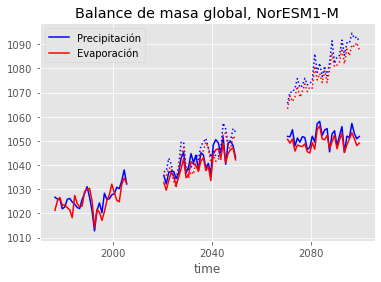

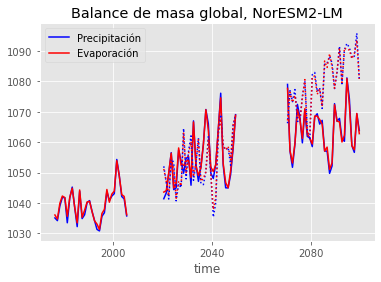

In [12]:
weights = np.cos(np.deg2rad(pr_c5_ens.lat))
media_pr_hist = pr_c5_ens.weighted(weights).mean(dim=('lat', 'lon'))
media_ev_hist = ev_c5_ens.weighted(weights).mean(dim=('lat', 'lon'))
with plt.style.context('ggplot'):
    media_pr_hist.plot(label='Precipitación', color='b')
    media_ev_hist.plot(label='Evaporación', color='r')
    plt.xlabel('Año')
    plt.ylabel('mm de agua')
    plt.legend()
    for i in dict_pr_ev_c5['RCP26']:
        i[0].weighted(weights).mean(dim=('lat', 'lon')).plot(color='b', linestyle='-')
        i[1].weighted(weights).mean(dim=('lat', 'lon')).plot(color='r', linestyle='-')
    for i in dict_pr_ev_c5['RCP85']:
        i[0].weighted(weights).mean(dim=('lat', 'lon')).plot(color='b', linestyle=':')
        i[1].weighted(weights).mean(dim=('lat', 'lon')).plot(color='r', linestyle=':')
    plt.title('Balance de masa global, NorESM1-M')
    plt.show()
    
    media_pr_hist = pr_c6_ens.weighted(weights).mean(dim=('lat', 'lon'))
    media_ev_hist = ev_c6_ens.weighted(weights).mean(dim=('lat', 'lon'))
    media_pr_hist.plot(label='Precipitación', color='b')
    media_ev_hist.plot(label='Evaporación', color='r')
    plt.xlabel('Año')
    plt.ylabel('mm de agua')
    plt.legend()
    for i in dict_pr_ev_c6['SSP126']:
        i[0].weighted(weights).mean(dim=('lat', 'lon')).plot(color='b', linestyle='-')
        i[1].weighted(weights).mean(dim=('lat', 'lon')).plot(color='r', linestyle='-')
    for i in dict_pr_ev_c6['SSP585']:
        i[0].weighted(weights).mean(dim=('lat', 'lon')).plot(color='b', linestyle=':')
        i[1].weighted(weights).mean(dim=('lat', 'lon')).plot(color='r', linestyle=':')
    plt.title('Balance de masa global, NorESM2-LM')
    plt.show()
    

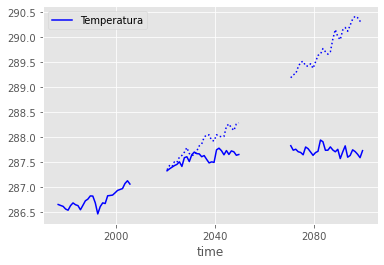

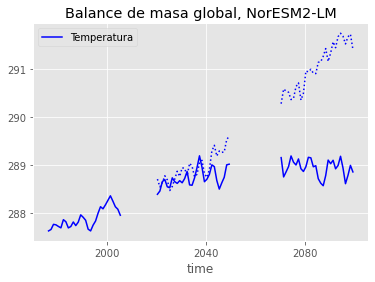

In [13]:
weights = np.cos(np.deg2rad(pr_c5_ens.lat))
media_t_hist = t_c5_ens.weighted(weights).mean(dim=('lat', 'lon'))
with plt.style.context('ggplot'):
    media_t_hist.plot(label='Temperatura', color='b')
    plt.xlabel('Año')
    plt.ylabel('mm de agua')
    plt.legend()
    for i in dict_t_c5['RCP26']:
        i[0].weighted(weights).mean(dim=('lat', 'lon')).plot(color='b', linestyle='-')
    for i in dict_t_c5['RCP85']:
        i[0].weighted(weights).mean(dim=('lat', 'lon')).plot(color='b', linestyle=':')

    plt.show()
    
    media_t_hist = t_c6_ens.weighted(weights).mean(dim=('lat', 'lon'))
    media_t_hist.plot(label='Temperatura', color='b')
    plt.xlabel('Año')
    plt.ylabel('mm de agua')
    plt.legend()
    for i in dict_t_c6['SSP126']:
        i[0].weighted(weights).mean(dim=('lat', 'lon')).plot(color='b', linestyle='-')
    for i in dict_t_c6['SSP585']:
        i[0].weighted(weights).mean(dim=('lat', 'lon')).plot(color='b', linestyle=':')
    plt.title('Balance de masa global, NorESM2-LM')
    plt.show()

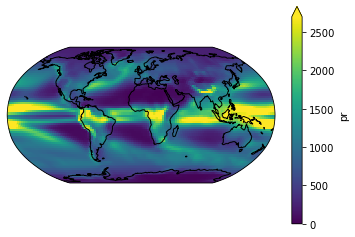

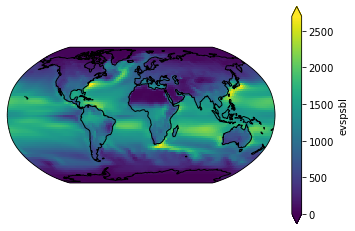

In [14]:
ax = plt.axes(projection=ccrs.Robinson())
pr_c5_ens.mean(dim='time').plot(vmin=0, vmax=2700, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

#plt.figure(figsize=(19,10))
ax = plt.axes(projection=ccrs.Robinson())
(ev_c5_ens.mean(dim='time')).plot(vmin=0, vmax=2700, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

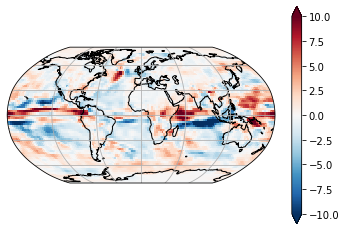

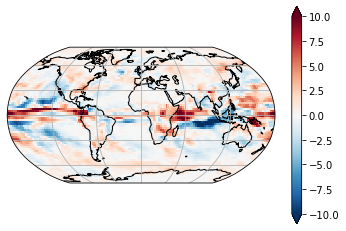

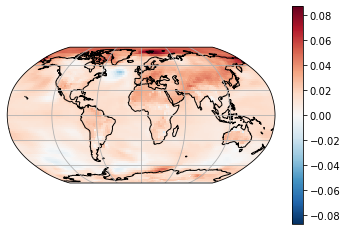

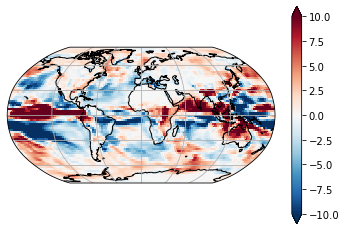

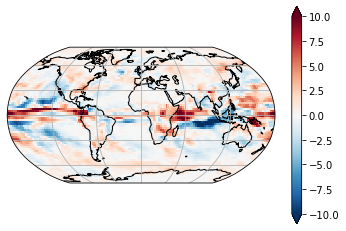

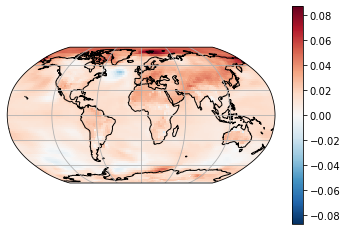

In [15]:

ax = plt.axes(projection=ccrs.Robinson())
xr_trends(pr_c5_ens - ev_c5_ens).plot(vmax=10, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.show()
ax = plt.axes(projection=ccrs.Robinson())
xr_trends(pr_c5_ens).plot(vmax=10, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.show()
ax = plt.axes(projection=ccrs.Robinson())
xr_trends(t_c5_ens).plot(vmax=None, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.show()


ax = plt.axes(projection=ccrs.Robinson())
xr_trends(pr_c5_85_far - ev_c5_85_far).plot(vmax=10, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.show()
ax = plt.axes(projection=ccrs.Robinson())
xr_trends(pr_c5_ens).plot(vmax=10, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.show()
ax = plt.axes(projection=ccrs.Robinson())
xr_trends(t_c5_ens).plot(vmax=None, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.show()

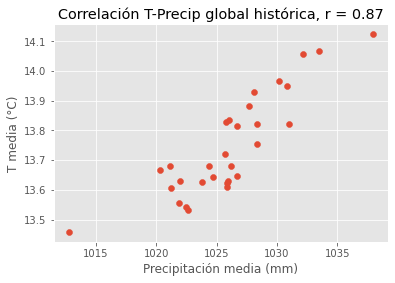

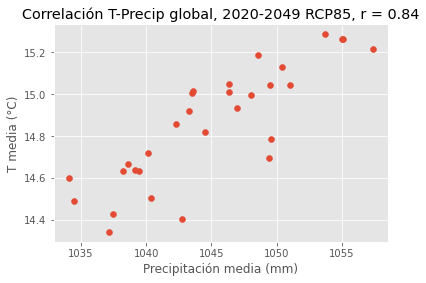

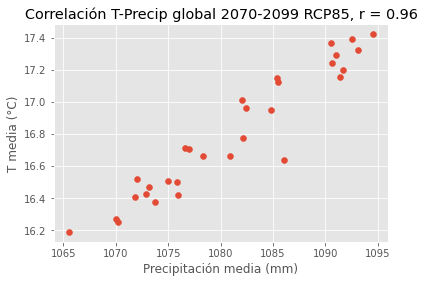

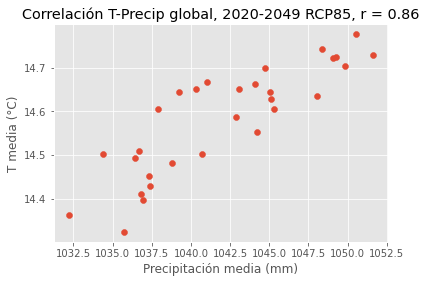

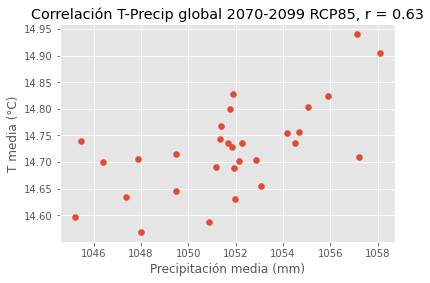

In [16]:
pr_c5_trend_hist = xr_trends(pr_c5_ens)
t_c5_trend_hist = xr_trends(t_c5_ens)

with plt.style.context('ggplot'):
    corr_pr_t_trend_hist = correlation(pr_c5_ens.weighted(weights).mean(dim=('lat', 'lon')), t_c5_ens.weighted(weights).mean(dim=('lat', 'lon')))
    plt.scatter(pr_c5_ens.weighted(weights).mean(dim=('lat', 'lon')).values,
                (t_c5_ens.weighted(weights).mean(dim=('lat', 'lon')).values - 273))
    plt.xlabel('Precipitación media (mm)')
    plt.ylabel('T media (°C)')
    plt.title('Correlación T-Precip global histórica, r = ' + str('{:.2f}'.format(corr_pr_t_trend_hist.values)))
    plt.show()
    
    corr_pr_t_trend_85_close = correlation(pr_c5_85_close.weighted(weights).mean(dim=('lat', 'lon')), t_c5_85_close.weighted(weights).mean(dim=('lat', 'lon')))
    plt.scatter(pr_c5_85_close.weighted(weights).mean(dim=('lat', 'lon')).values,
                (t_c5_85_close.weighted(weights).mean(dim=('lat', 'lon')).values - 273))
    plt.xlabel('Precipitación media (mm)')
    plt.ylabel('T media (°C)')
    plt.title('Correlación T-Precip global, 2020-2049 RCP85, r = ' + str('{:.2f}'.format(corr_pr_t_trend_85_close.values)))
    plt.show()
    
    
    corr_pr_t_trend_85_far = correlation(pr_c5_85_far.weighted(weights).mean(dim=('lat', 'lon')), t_c5_85_far.weighted(weights).mean(dim=('lat', 'lon')))
    plt.scatter(pr_c5_85_far.weighted(weights).mean(dim=('lat', 'lon')).values,
                (t_c5_85_far.weighted(weights).mean(dim=('lat', 'lon')).values - 273))
    plt.xlabel('Precipitación media (mm)')
    plt.ylabel('T media (°C)')
    plt.title('Correlación T-Precip global 2070-2099 RCP85, r = ' + str('{:.2f}'.format(corr_pr_t_trend_85_far.values)))
    plt.show()
    
    
    corr_pr_t_trend_26_close = correlation(pr_c5_26_close.weighted(weights).mean(dim=('lat', 'lon')), t_c5_26_close.weighted(weights).mean(dim=('lat', 'lon')))
    plt.scatter(pr_c5_26_close.weighted(weights).mean(dim=('lat', 'lon')).values,
                (t_c5_26_close.weighted(weights).mean(dim=('lat', 'lon')).values - 273))
    plt.xlabel('Precipitación media (mm)')
    plt.ylabel('T media (°C)')
    plt.title('Correlación T-Precip global, 2020-2049 RCP85, r = ' + str('{:.2f}'.format(corr_pr_t_trend_26_close.values)))
    plt.show()
    
    
    corr_pr_t_trend_26_far = correlation(pr_c5_26_far.weighted(weights).mean(dim=('lat', 'lon')), t_c5_26_far.weighted(weights).mean(dim=('lat', 'lon')))
    plt.scatter(pr_c5_26_far.weighted(weights).mean(dim=('lat', 'lon')).values,
                (t_c5_26_far.weighted(weights).mean(dim=('lat', 'lon')).values - 273))
    plt.xlabel('Precipitación media (mm)')
    plt.ylabel('T media (°C)')
    plt.title('Correlación T-Precip global 2070-2099 RCP85, r = ' + str('{:.2f}'.format(corr_pr_t_trend_26_far.values)))
    plt.show()
    

(30,)


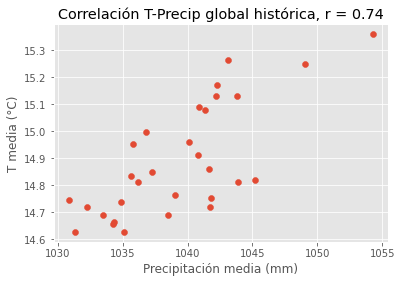

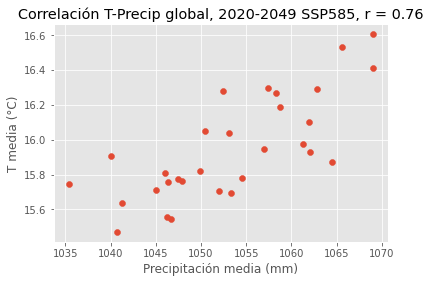

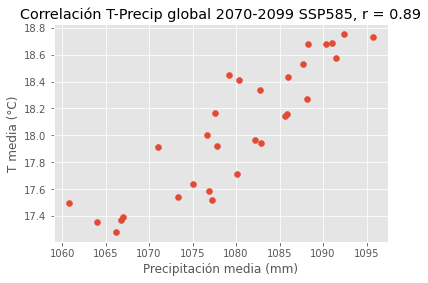

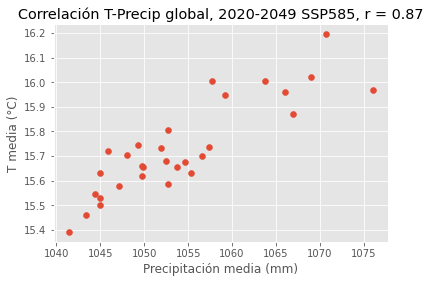

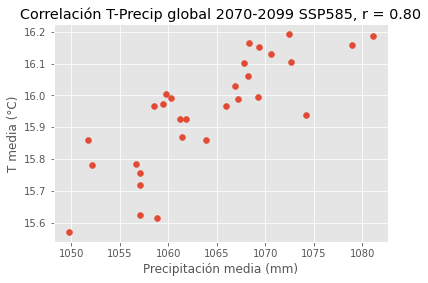

In [17]:
pr_c6_trend_hist = xr_trends(pr_c6_ens)
t_c6_trend_hist = xr_trends(t_c6_ens)

print((t_c6_ens.weighted(weights).mean(dim=('lat', 'lon')).shape))
with plt.style.context('ggplot'):
    corr_pr_t_trend_hist = correlation(pr_c6_ens.weighted(weights).mean(dim=('lat', 'lon')), t_c6_ens.weighted(weights).mean(dim=('lat', 'lon')))
    plt.scatter(pr_c6_ens.weighted(weights).mean(dim=('lat', 'lon')).values,
                (t_c6_ens.weighted(weights).mean(dim=('lat', 'lon')).values - 273))
    plt.xlabel('Precipitación media (mm)')
    plt.ylabel('T media (°C)')
    plt.title('Correlación T-Precip global histórica, r = ' + str('{:.2f}'.format(corr_pr_t_trend_hist.values)))
    plt.show()
    
    corr_pr_t_trend_585_close = correlation(pr_c6_585_close.weighted(weights).mean(dim=('lat', 'lon')), t_c6_585_close.weighted(weights).mean(dim=('lat', 'lon')))
    plt.scatter(pr_c6_585_close.weighted(weights).mean(dim=('lat', 'lon')).values,
                (t_c6_585_close.weighted(weights).mean(dim=('lat', 'lon')).values - 273))
    plt.xlabel('Precipitación media (mm)')
    plt.ylabel('T media (°C)')
    plt.title('Correlación T-Precip global, 2020-2049 SSP585, r = ' + str('{:.2f}'.format(corr_pr_t_trend_585_close.values)))
    plt.show()
    
    
    corr_pr_t_trend_585_far = correlation(pr_c6_585_far.weighted(weights).mean(dim=('lat', 'lon')), t_c6_585_far.weighted(weights).mean(dim=('lat', 'lon')))
    plt.scatter(pr_c6_585_far.weighted(weights).mean(dim=('lat', 'lon')).values,
                (t_c6_585_far.weighted(weights).mean(dim=('lat', 'lon')).values - 273))
    plt.xlabel('Precipitación media (mm)')
    plt.ylabel('T media (°C)')
    plt.title('Correlación T-Precip global 2070-2099 SSP585, r = ' + str('{:.2f}'.format(corr_pr_t_trend_585_far.values)))
    plt.show()
    
    
    corr_pr_t_trend_126_close = correlation(pr_c6_126_close.weighted(weights).mean(dim=('lat', 'lon')), t_c6_126_close.weighted(weights).mean(dim=('lat', 'lon')))
    plt.scatter(pr_c6_126_close.weighted(weights).mean(dim=('lat', 'lon')).values,
                (t_c6_126_close.weighted(weights).mean(dim=('lat', 'lon')).values - 273))
    plt.xlabel('Precipitación media (mm)')
    plt.ylabel('T media (°C)')
    plt.title('Correlación T-Precip global, 2020-2049 SSP585, r = ' + str('{:.2f}'.format(corr_pr_t_trend_126_close.values)))
    plt.show()
    
    
    corr_pr_t_trend_126_far = correlation(pr_c6_126_far.weighted(weights).mean(dim=('lat', 'lon')), t_c6_126_far.weighted(weights).mean(dim=('lat', 'lon')))
    plt.scatter(pr_c6_126_far.weighted(weights).mean(dim=('lat', 'lon')).values,
                (t_c6_126_far.weighted(weights).mean(dim=('lat', 'lon')).values - 273))
    plt.xlabel('Precipitación media (mm)')
    plt.ylabel('T media (°C)')
    plt.title('Correlación T-Precip global 2070-2099 SSP585, r = ' + str('{:.2f}'.format(corr_pr_t_trend_126_far.values)))
    plt.show()
    

In [85]:
#df_p_e = pd.Dataframe()

def tabla_bandas_latitud_peixoto(pr, ev):
    """Calcula tabla de Pr y Ev para bandas de
    longitud. Devuelve un DataFrame estilizado"""
    
    def format_df(df):
    ds = df.style.format({'Area': '{:.1f}', 'P': '{:.0f}', 'E': '{:.0f}',
                     'P-E': '{:.0f}', 'E/P': '{:.2f}', '(P-E)/P': '{:.2f}'}) 
    return ds

    p_e_df = pd.DataFrame(columns=['Lat', 'Area', 'P', 'E', 'P-E', 'E/P', '(P-E)/P'])
    weights = np.cos(np.deg2rad(pr.lat))
    def nice_lat(lat):
        if lat < 0:
            nice = str(np.abs(lat)) + '°S'
        elif lat > 0:
            nice = str(np.abs(lat)) + '°N'
        elif lat == 0:
            nice = str(np.abs(lat)) + '°'
        return nice

    for i in range(90, -90, -10):
        precip = ((pr ).where(
                  pr.lat <= i).where(pr.lat > (i - 10)).weighted(
                  weights).mean(dim=('lat', 'lon', 'time')).values)
        evap = ((ev).where(
                ev.lat <= i).where(ev.lat > (i - 10)).weighted(
                weights).mean(dim=('lat', 'lon', 'time')).values)
        df2 = pd.DataFrame([[nice_lat(i - 10) + ' - ' + nice_lat((i)), 
                             area_banda(i, i-10) / 10**12,
                             precip, evap, precip-evap,
                             evap/precip, (precip-evap)/precip]],
                       columns=['Lat', 'Area', 'P', 'E', 'P-E', 'E/P', '(P-E)/P'])
        p_e_df =  p_e_df.append(df2)
    
    # Agrego hemisferio y globo
    precip = pr.where(pr.lat > 0).weighted(weights).mean(
                dim=('lat', 'lon', 'time')).values
    evap = ev.where(ev.lat > 0).weighted(weights).mean(
              dim=('lat', 'lon', 'time')).values
    df2 = pd.DataFrame([['HN', area_banda(0, 90) / 10**12,
                        precip, evap, precip-evap,
                        evap/precip, (precip-evap)/precip]],
                        columns=['Lat', 'Area', 'P', 'E', 'P-E', 'E/P', '(P-E)/P'])
    p_e_df =  p_e_df.append(df2)
    
    precip = pr.where(pr.lat < 0).weighted(weights).mean(
                dim=('lat', 'lon', 'time')).values
    evap = ev.where(ev.lat < 0).weighted(weights).mean(
              dim=('lat', 'lon', 'time')).values
    df2 = pd.DataFrame([['HS', area_banda(-90, 0) / 10**12,
                        precip, evap, precip-evap,
                        evap/precip, (precip-evap)/precip]],
                        columns=['Lat', 'Area', 'P', 'E', 'P-E', 'E/P', '(P-E)/P'])
    p_e_df =  p_e_df.append(df2)
    
    precip = pr.weighted(weights).mean(
                dim=('lat', 'lon', 'time')).values
    evap = ev.weighted(weights).mean(
              dim=('lat', 'lon', 'time')).values
    df2 = pd.DataFrame([['Globo', area_banda(-90, 90) / 10**12,
                        precip, evap, precip-evap,
                        evap/precip, (precip-evap)/precip]],
                        columns=['Lat', 'Area', 'P', 'E', 'P-E', 'E/P', '(P-E)/P'])
    p_e_df =  p_e_df.append(df2)
    
    return format_df(p_e_df.set_index('Lat'))


In [86]:
tabla_hist_cmip5 = tabla_bandas_latitud_peixoto(pr_c5_ens, ev_c5_ens)
display(tabla_hist_cmip5)

tabla_26_close = tabla_bandas_latitud_peixoto(pr_c5_26_close, ev_c5_26_close)
display(tabla_26_close)

tabla_26_far = tabla_bandas_latitud_peixoto(pr_c5_26_far, ev_c5_26_far)
display(tabla_26_far)

,Area,P,E,P-E,E/P,(P-E)/P
Lat,,,,,,
80°N - 90°N,3.9,247,32,215,0.13,0.87
70°N - 80°N,11.5,329,115,214,0.35,0.65
60°N - 70°N,18.8,564,244,320,0.43,0.57
50°N - 60°N,25.5,802,501,301,0.62,0.38
40°N - 50°N,31.4,847,639,207,0.76,0.24
30°N - 40°N,36.4,932,1017,-85,1.09,-0.09
20°N - 30°N,40.3,614,1109,-495,1.81,-0.81
10°N - 20°N,42.9,923,1399,-476,1.52,-0.52
0° - 10°N,44.3,1989,1413,576,0.71,0.29


,Area,P,E,P-E,E/P,(P-E)/P
Lat,,,,,,
80°N - 90°N,3.9,276,36,240,0.13,0.87
70°N - 80°N,11.5,362,140,222,0.39,0.61
60°N - 70°N,18.8,595,261,334,0.44,0.56
50°N - 60°N,25.5,829,513,316,0.62,0.38
40°N - 50°N,31.4,870,652,218,0.75,0.25
30°N - 40°N,36.4,939,1038,-99,1.11,-0.11
20°N - 30°N,40.3,617,1124,-507,1.82,-0.82
10°N - 20°N,42.9,941,1420,-479,1.51,-0.51
0° - 10°N,44.3,2054,1424,629,0.69,0.31


,Area,P,E,P-E,E/P,(P-E)/P
Lat,,,,,,
80°N - 90°N,3.9,269,37,232,0.14,0.86
70°N - 80°N,11.5,367,145,222,0.40,0.60
60°N - 70°N,18.8,615,275,340,0.45,0.55
50°N - 60°N,25.5,844,524,319,0.62,0.38
40°N - 50°N,31.4,887,670,217,0.76,0.24
30°N - 40°N,36.4,967,1063,-96,1.10,-0.10
20°N - 30°N,40.3,627,1144,-517,1.82,-0.82
10°N - 20°N,42.9,954,1438,-483,1.51,-0.51
0° - 10°N,44.3,2077,1435,642,0.69,0.31


In [55]:
tabla_hist_cmip6 = tabla_bandas_latitud_peixoto(pr_c6_ens, ev_c6_ens)
display(tabla_hist_cmip6)

tabla_126_close = tabla_bandas_latitud_peixoto(pr_c6_126_close, ev_c6_126_close)
display(tabla_126_close)

tabla_126_far = tabla_bandas_latitud_peixoto(pr_c6_126_far, ev_c6_126_far)
display(tabla_126_far)

tabla_585_close = tabla_bandas_latitud_peixoto(pr_c6_585_close, ev_c6_585_close)
display(tabla_585_close)

tabla_585_far = tabla_bandas_latitud_peixoto(pr_c6_585_far, ev_c6_585_far)
display(tabla_585_far)

,Area,P,E,P-E,E/P,(P-E)/P
Lat,,,,,,
80°N - 90°N,3.9,234,23,211,0.10,0.90
70°N - 80°N,11.5,316,106,209,0.34,0.66
60°N - 70°N,18.8,616,248,368,0.40,0.60
50°N - 60°N,25.5,845,469,375,0.56,0.44
40°N - 50°N,31.4,839,551,288,0.66,0.34
30°N - 40°N,36.4,909,969,-61,1.07,-0.07
20°N - 30°N,40.3,685,1104,-419,1.61,-0.61
10°N - 20°N,42.9,1002,1450,-447,1.45,-0.45
0° - 10°N,44.3,1780,1476,303,0.83,0.17


,Area,P,E,P-E,E/P,(P-E)/P
Lat,,,,,,
80°N - 90°N,3.9,258,24,234,0.09,0.91
70°N - 80°N,11.5,337,96,241,0.28,0.72
60°N - 70°N,18.8,644,251,393,0.39,0.61
50°N - 60°N,25.5,868,463,405,0.53,0.47
40°N - 50°N,31.4,869,569,299,0.66,0.34
30°N - 40°N,36.4,928,997,-69,1.07,-0.07
20°N - 30°N,40.3,704,1168,-464,1.66,-0.66
10°N - 20°N,42.9,1077,1470,-393,1.36,-0.36
0° - 10°N,44.3,1948,1492,456,0.77,0.23


,Area,P,E,P-E,E/P,(P-E)/P
Lat,,,,,,
80°N - 90°N,3.9,267,25,243,0.09,0.91
70°N - 80°N,11.5,355,107,248,0.30,0.70
60°N - 70°N,18.8,645,250,396,0.39,0.61
50°N - 60°N,25.5,873,453,419,0.52,0.48
40°N - 50°N,31.4,882,580,302,0.66,0.34
30°N - 40°N,36.4,923,1003,-80,1.09,-0.09
20°N - 30°N,40.3,731,1190,-459,1.63,-0.63
10°N - 20°N,42.9,1087,1486,-399,1.37,-0.37
0° - 10°N,44.3,1985,1511,474,0.76,0.24


,Area,P,E,P-E,E/P,(P-E)/P
Lat,,,,,,
80°N - 90°N,3.9,266,25,241,0.10,0.90
70°N - 80°N,11.5,346,101,245,0.29,0.71
60°N - 70°N,18.8,655,256,399,0.39,0.61
50°N - 60°N,25.5,869,468,401,0.54,0.46
40°N - 50°N,31.4,869,574,295,0.66,0.34
30°N - 40°N,36.4,918,995,-77,1.08,-0.08
20°N - 30°N,40.3,709,1158,-448,1.63,-0.63
10°N - 20°N,42.9,1064,1467,-403,1.38,-0.38
0° - 10°N,44.3,1958,1494,464,0.76,0.24


,Area,P,E,P-E,E/P,(P-E)/P
Lat,,,,,,
80°N - 90°N,3.9,350,52,298,0.15,0.85
70°N - 80°N,11.5,433,150,284,0.35,0.65
60°N - 70°N,18.8,716,267,448,0.37,0.63
50°N - 60°N,25.5,919,455,464,0.50,0.50
40°N - 50°N,31.4,905,601,304,0.66,0.34
30°N - 40°N,36.4,919,1021,-102,1.11,-0.11
20°N - 30°N,40.3,763,1224,-461,1.60,-0.60
10°N - 20°N,42.9,1152,1502,-350,1.30,-0.30
0° - 10°N,44.3,2101,1525,576,0.73,0.27


In [106]:
def tabla_regiones_peixoto(pr, ev, dmasks_land, dmasks_ocean):
    """Calcula tabla de Pr y Ev para regiones.
    Devuelve un DataFrame estilizado"""
    
    def format_df(df):
        ds = df.style.format({'Area': '{:.1f}', 'P': '{:.0f}', 'E': '{:.0f}',
                     'P-E': '{:.0f}', 'E/P': '{:.2f}', '(P-E)/P': '{:.2f}'}) 
        return ds
    p_e_df = pd.DataFrame(columns=['Región', 'Area', 'P', 'E', 'P-E', 'E/P', '(P-E)/P'])
    weights = np.cos(np.deg2rad(pr.lat)) 
    for region in dmasks_land:
        precip = pr.where(dmasks_land[region]==1).weighted(weights).mean().values
        evap = ev.where(dmasks_land[region]==1).weighted(weights).mean().values
        df2 = pd.DataFrame([[region, area_celda(dmasks_land[region].lat.where(
                                     dmasks_land[region]==1)).sum().values / 10**12,
                          precip, evap, precip-evap,
                          evap/precip, (precip-evap)/precip]],
                          columns=['Región', 'Area', 'P', 'E', 'P-E', 'E/P', '(P-E)/P'])
        p_e_df = p_e_df.append(df2)
    
    ###### Todo continente
    precip = pr.where(np.isfinite(maskLND)).weighted(weights).mean().values
    evap = ev.where(np.isfinite(maskLND)).weighted(weights).mean().values
    df2 = pd.DataFrame([['Continentes', area_celda(maskLND.lat.where(
                                 np.isfinite(maskLND))).sum().values / 10**12,
                      precip, evap, precip-evap,
                      evap/precip, (precip-evap)/precip]],
                      columns=['Región', 'Area', 'P', 'E', 'P-E', 'E/P', '(P-E)/P'])
    p_e_df = p_e_df.append(df2)
    
    for region in dmasks_ocean:
        precip = pr.where(dmasks_ocean[region]==1).weighted(weights).mean().values
        evap = ev.where(dmasks_ocean[region]==1).weighted(weights).mean().values
        df2 = pd.DataFrame([[region, area_celda(dmasks_ocean[region].lat.where(
                                     dmasks_ocean[region]==1)).sum().values / 10**12,
                          precip, evap, precip-evap,
                          evap/precip, (precip-evap)/precip]],
                          columns=['Región', 'Area', 'P', 'E', 'P-E', 'E/P', '(P-E)/P'])
        p_e_df = p_e_df.append(df2)
        
    ###### Todo océano
    precip = pr.where(np.isnan(maskLND)).weighted(weights).mean().values
    evap = ev.where(np.isnan(maskLND)).weighted(weights).mean().values
    df2 = pd.DataFrame([['Océanos', area_celda(maskLND.lat.where(
                                 np.isnan(maskLND))).sum().values / 10**12,
                      precip, evap, precip-evap,
                      evap/precip, (precip-evap)/precip]],
                      columns=['Región', 'Area', 'P', 'E', 'P-E', 'E/P', '(P-E)/P'])
    p_e_df = p_e_df.append(df2)
    
    return format_df(p_e_df.set_index('Región'))

In [107]:
tabla_regiones_hist = tabla_regiones_peixoto(pr_c5_ens, ev_c5_ens, masks_land, masks_ocean)
display(tabla_regiones_)

,Area,P,E,P-E,E/P,(P-E)/P
Región,,,,,,
Norteamérica,28.9,729,532,197,0.73,0.27
Sudamérica,19.0,1393,1048,345,0.75,0.25
África,33.7,913,762,150,0.84,0.16
Europa,9.1,764,592,172,0.78,0.22
Asia,46.7,663,484,179,0.73,0.27
Cont. Marítimo,10.1,2439,1411,1028,0.58,0.42
Australia,10.1,961,908,53,0.94,0.06
Antártida,12.2,188,15,174,0.08,0.92
Continentes,148.0,845,593,252,0.70,0.30


In [ ]:
balance_agua_hist = pr_c5_ens - ev_c5_ens
ax = plt.axes(projection=ccrs.Robinson())
balance_agua_hist.mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
plt.show()
balance_agua_85_close = pr_c5_85_close - ev_c5_85_close
ax = plt.axes(projection=ccrs.Robinson())
balance_agua_85_close.mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True)
ax.coastlines()
plt.show()
ax = plt.axes(projection=ccrs.Robinson())
(balance_agua_85_close.mean(dim='time') - balance_agua_hist.mean(dim='time')).plot(
  transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()